# Learning a single edge filter
Let's create a minimal CNN which learn a single edge filter

In [1]:
# Viz imports
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()

import sys
import os

# Numpy
import numpy as np
from skimage import color, io

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# Torchvision
import torchvision.utils
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Dataset: CIFAR10 https://www.cs.toronto.edu/~kriz/cifar.html
from torchvision.datasets import CIFAR10

## Training params

In [2]:
num_epochs = 10
batch_size = 512
learning_rate = 1e-1
use_gpu = True

## Dataset

In [3]:
gt_edge_filter = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
gt_edge_filter.weight.data = torch.FloatTensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]]).view(1, 1, 3, 3)

def edge_filter(img):
    with torch.no_grad():
        return gt_edge_filter(img.unsqueeze(0)).squeeze(0)

class EdgeImageDataset(Dataset):
    
    def __init__(self, root, train=True):
        self.cifar = CIFAR10(root=root, train=train, transform=None, target_transform=None, download=True)
        
        self.img_transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor()
        ])
        
        self.img2edge_transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Lambda(edge_filter)
        ])
    
    def __getitem__(self, index):
        img = self.cifar[index][0]
        return (self.img_transform(img), self.img2edge_transform(img))
        
    def __len__(self):
        return len(self.cifar)

train_dataset = EdgeImageDataset('./data/CIFAR10', train=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = EdgeImageDataset('./data/CIFAR10', train=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

100.0%


Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


## CNN

In [5]:
class EdgeNet(nn.Module):
    def __init__(self, d=128):
        super(EdgeNet, self).__init__()
        
        # We will not be using bias, so the learned kernel closely matches the one generating the data. 
        self.conv = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)

    def forward(self, input):
        return self.conv(input)

enet = EdgeNet()

# Device
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
enet = enet.to(device)
print('Using device: %s' % (device))

# Show # params (single 3x3 kernel with no bias)
num_params = sum(p.numel() for p in enet.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

Using device: cuda:0
Number of parameters: 9


## Training loop

In [6]:
# Adam Optimizer
optimizer = torch.optim.Adam(params=enet.parameters(), lr=learning_rate)

# Training mode
enet.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, edge_batch in train_dataloader:
        
        # Get data
        image_batch = image_batch.to(device)
        edge_batch = edge_batch.to(device)
        
        # Predict
        predicted_edge_batch = enet(image_batch)
        
        # Compare against GT
        loss = F.mse_loss(predicted_edge_batch, edge_batch)
        
        # Backprop. (gradient computation)
        optimizer.zero_grad()
        loss.backward()
        
        # Update optimizer
        optimizer.step()
        
        # Loss tracking (for viz. purposes)
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average loss: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 10] average loss: 0.061792
Epoch [2 / 10] average loss: 0.000527
Epoch [3 / 10] average loss: 0.000183
Epoch [4 / 10] average loss: 0.000048
Epoch [5 / 10] average loss: 0.000009
Epoch [6 / 10] average loss: 0.000001
Epoch [7 / 10] average loss: 0.000000
Epoch [8 / 10] average loss: 0.000000
Epoch [9 / 10] average loss: 0.000000
Epoch [10 / 10] average loss: 0.000000


## Loss plot

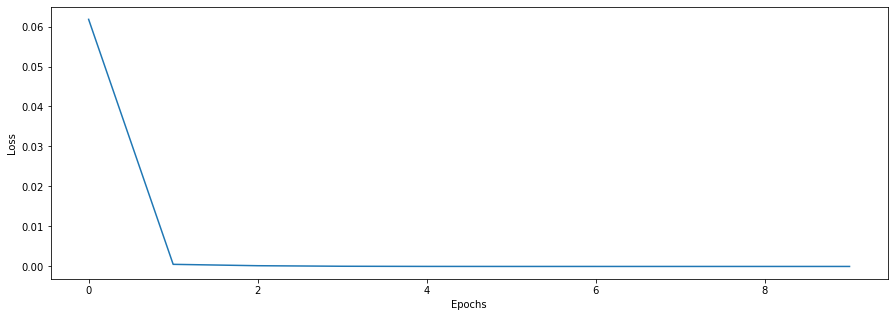

In [7]:
fig = plt.figure(figsize=(15, 5))
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [8]:
# In case we want to save CNN
# torch.save(enet.state_dict(), './border_detector.pth')

## Testing

In [9]:
# Evaluate network performance
enet.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, edge_batch in test_dataloader:

    with torch.no_grad():
   
        image_batch = image_batch.to(device)
        edge_batch  = edge_batch.to(device)

        # Predict 
        predicted_edge_batch = enet(image_batch)

        # Compute MSE 
        loss = F.mse_loss(predicted_edge_batch, edge_batch)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))

average loss: 0.000000


learned edge filter
[[[[ 1.0001251e+00 -1.9791469e-04 -9.9991357e-01]
   [ 1.9997656e+00  3.7082116e-04 -2.0001640e+00]
   [ 1.0001274e+00 -2.0240578e-04 -9.9990970e-01]]]]
ground truth edge filter
[[[[ 1.  0. -1.]
   [ 2.  0. -2.]
   [ 1.  0. -1.]]]]


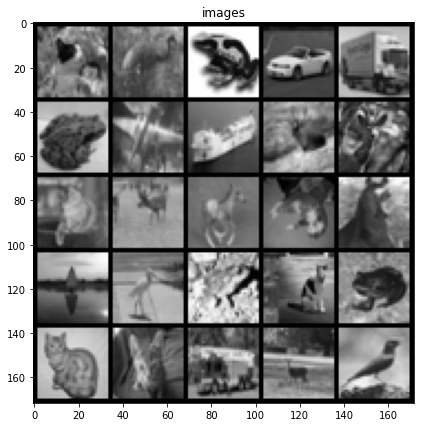

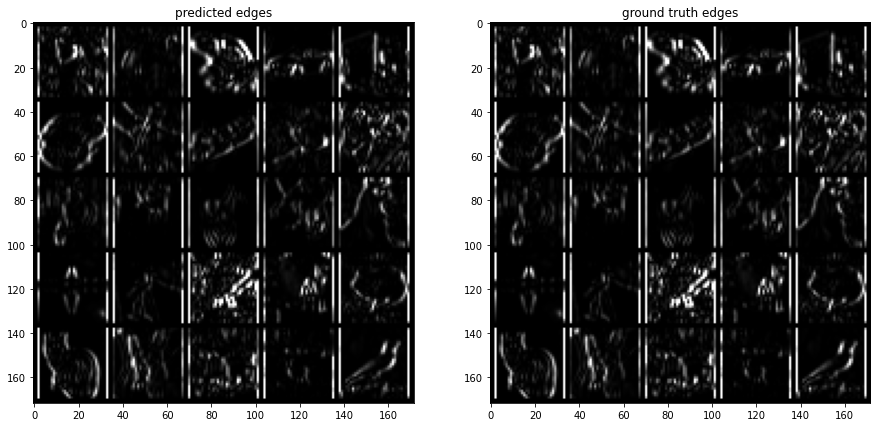

In [10]:
# Let's compare 
with torch.no_grad():

    # Some random images
    image_inds  = np.random.choice(len(test_dataset), 25, replace=False)
    image_batch = torch.stack([test_dataset[i][0] for i in image_inds])
    edge_batch  = torch.stack([test_dataset[i][1] for i in image_inds])
    image_batch = image_batch.to(device)

    # Predict borders
    predicted_edge_batch = enet(image_batch)

    # Bring them to CPU (required to viz.)
    image_batch.cpu()
    predicted_edge_batch.cpu()

    # Get edge magnitudes in [0,1]
    predicted_edge_batch = ((predicted_edge_batch/4.0).pow(2)*4.0).clamp(min=0, max=1)
    edge_batch           = ((edge_batch/4.0).pow(2)*4.0).clamp(min=0, max=1)

    print('learned edge filter')
    print(enet.conv.weight.cpu().detach().numpy())

    print('ground truth edge filter')
    print(gt_edge_filter.weight.cpu().detach().numpy())

    # plot images
    fig, ax = plt.subplots(figsize=(7, 7), nrows=1, ncols=1)
    ax.imshow(np.transpose(torchvision.utils.make_grid(image_batch, nrow=5).cpu().numpy(), (1, 2, 0)))
    ax.title.set_text('images')

    # plot edges
    fig, ax = plt.subplots(figsize=(15, 15), nrows=1, ncols=2)
    ax[0].imshow(np.transpose(torchvision.utils.make_grid(predicted_edge_batch, nrow=5).cpu().numpy(), (1, 2, 0)))
    ax[0].title.set_text('predicted edges')
    ax[1].imshow(np.transpose(torchvision.utils.make_grid(edge_batch, nrow=5).cpu().numpy(), (1, 2, 0)))
    ax[1].title.set_text('ground truth edges')
    plt.show()